In [1]:
import sys
sys.path.append("../")

# Evaluation

In [13]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import Compose, ToTensor, ToPILImage

from model import UNet
from predict import Predictor
from data import NucleusDataset
from transform import Rescale
from metrics import iou_score
from losses import bce_and_dice

Load the training and test data sets

In [3]:
train_dataset = NucleusDataset("../data", train=True, 
                               transform=Compose([
                                   Rescale(256)
                               ]),
                               target_transform=Compose([
                                   Rescale(256)
                               ]))
test_dataset = NucleusDataset("../data", train=False,
                              transform=Compose([
                                   Rescale(256)
                               ]))

100%|██████████| 65/65 [00:00<00:00, 134.22it/s]


Load the pretrained model

In [45]:
model = UNet.load("../models/test3/weights_e:40_loss:0.0496.pt")

Loading UNet from path `../models/test3/weights_e:40_loss:0.0496.pt`


Crete predictor

In [46]:
predict = Predictor(model)

Plot some of the images and masks from the dataset, as well as model predictions

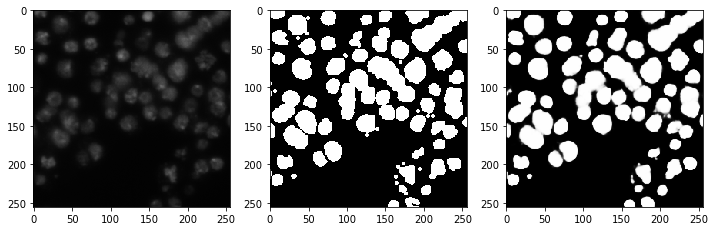

In [31]:
idx = random.randint(0, len(train_dataset)-1)
image, mask = train_dataset[idx]

segmented = predict(image)

fig, axes = plt.subplots(1, 3, figsize=(12, 10))
axes[0].imshow(image)
axes[1].imshow(mask, cmap="gray")
axes[2].imshow(segmented, cmap="gray")

plt.show()

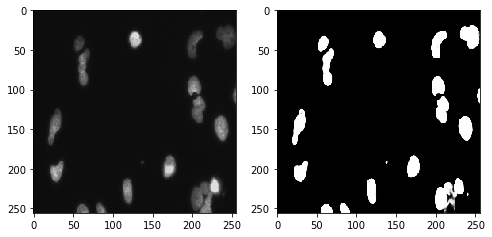

In [34]:
idx = random.randint(0, len(test_dataset)-1)
image = test_dataset[idx]

segmented = predict(image)

fig, axes = plt.subplots(1, 2, figsize=(8, 10))
axes[0].imshow(image)
axes[1].imshow(segmented, cmap="gray")

plt.show()

## Worst examples on train set

In [12]:
to_tensor = ToTensor()

def compute_loss(segmented, mask):
    segmented_tensor = to_tensor(segmented)
    mask_tensor = to_tensor(mask)
    
    segmented_tensor = segmented_tensor.unsqueeze(0)
    mask_tensor = mask_tensor.unsqueeze(0)
    
    loss = bce_and_dice(segmented_tensor, mask_tensor)
    
    return loss.item()

Obtain loss for every image

In [50]:
losses = []
for i in tqdm(range(len(train_dataset))):
    img, mask = train_dataset[i]
    segmented = predict(img)
    
    loss = compute_loss(segmented, mask)
    losses.append({
        "loss": loss,
        "img": img,
        "segmented": segmented,
        "mask": mask,
        "idx": i
    })

100%|██████████| 670/670 [02:30<00:00,  4.46it/s]


Sort a list of losses

In [51]:
losses.sort(key=lambda x: x["loss"], reverse=True)

Examine top 10 worst images (highest loss)

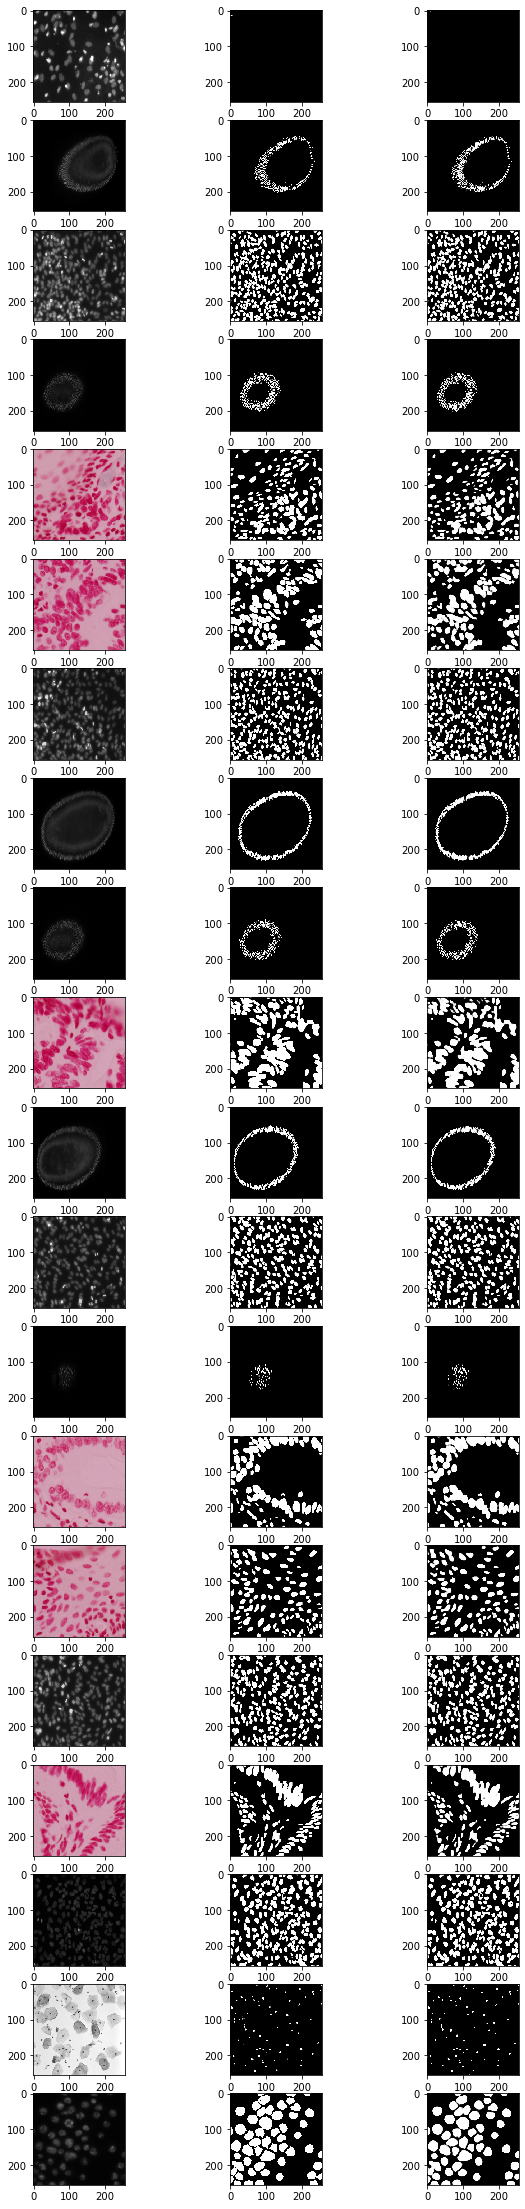

In [52]:
num_samples = 20
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 40))

for i in range(num_samples):
    data = losses[i]
    axes[i][0].imshow(data["img"])
    axes[i][1].imshow(data["mask"], cmap="gray")
    axes[i][2].imshow(data["segmented"], cmap="gray")

## Is the same thing happening on test set?

In [47]:
losses = []
for i in tqdm(range(len(test_dataset))):
    img = test_dataset[i]
    segmented = predict(img)
    
    loss = compute_loss(segmented, mask)
    losses.append({
        "loss": loss,
        "img": img,
        "segmented": segmented,
        "idx": i
    })

100%|██████████| 65/65 [00:14<00:00,  4.42it/s]


In [48]:
losses.sort(key=lambda x: x["loss"], reverse=True)

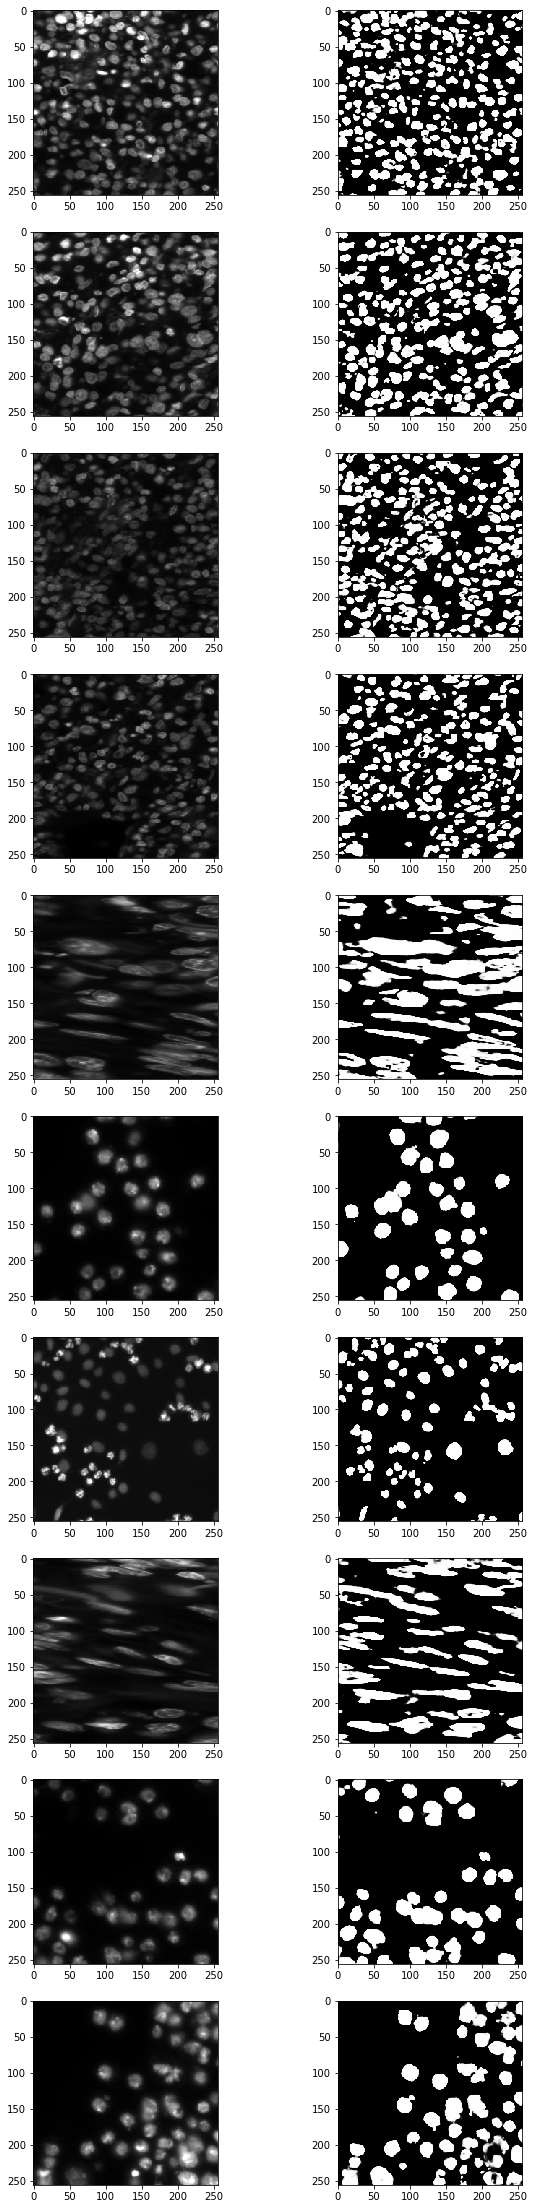

In [49]:
num_samples = 10
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 40))

for i in range(num_samples):
    data = losses[i]
    axes[i][0].imshow(data["img"])
    axes[i][1].imshow(data["segmented"], cmap="gray")